In [105]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime

# sac-specific
from sac_utils.createAOI import create_lat_lon

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


## **Summary**
- (1) create T1-1m water mask & prep T1 image
    - load available T1-1m water masks (naturally L8 for now)
    - load T1 dataset (L8 for now too)
    - apply T1 dataset clearsky mask
- (2) check class distributions of T1 image w/ T1-1m water mask
- (3) train classifier on T1 image w/ T1-1m water mask
- (4) run classifier on full T1 image
- (5) export results & underlying image + masks

## (1) create T1-1m water mask & prep T1 image

set consistent dc query params

In [115]:
# arbitrary time period of month. Will use most recent image for inference
time_start = ('2018-1-1')
time_end = ('2018-4-1')
# arbitrary small-ish aoi (over suva)
aoi_wkt = "POLYGON((178.5084149387392 -18.103042187047517,178.54017229347554 -18.103042187047517,178.54017229347554 -18.12392593522968,178.5084149387392 -18.12392593522968,178.5084149387392 -18.103042187047517))"
# resulution chosen for speed
res = 30

output_crs = "EPSG:32760"
latitude, longitude = create_lat_lon(aoi_wkt)
# latitude = (-18.2962, -17.2867)
# longitude = (177.1594, 178.7222)
resolution = (-res, res)
def createDate(inputDate):
    outputDate = datetime.strptime(inputDate, '%Y-%m-%d')
    outputDates = outputDate.date()
    return outputDates
dateStart = createDate(time_start)
dateEnd = createDate(time_end)
time_extents = (dateStart, dateEnd)

### load available T1-1m water masks 
- (naturally L8 for now)

load T1-1m water masks

In [116]:
# dc.find_datasets(
#     product=product,
#     time=time_extents,
#     lat=latitude,
#     lon=longitude,
#     output_crs=output_crs,
#     resolution=resolution,
#     measurements = measurements
# )

In [174]:
product = 'ls8_water_classification'
measurements = ['water']

water_dataset = dc.load(
    product=product,
    time=time_extents,
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:  (time: 12, x: 113, y: 79)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T22:00:35 ... 2018-03-31T22:06:04
  * y        (y) float64 7.998e+06 7.998e+06 7.998e+06 ... 7.995e+06 7.995e+06
  * x        (x) float64 6.596e+05 6.596e+05 6.597e+05 ... 6.629e+05 6.63e+05
Data variables:
    water    (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
Attributes:
    crs:      EPSG:32760

fully remove nodata pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [175]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

define computation of water summary product

In [176]:
mean_dataset = water_dataset.water.mean(dim='time')

apply computation to water masks dataset & plot

In [177]:
%%time
mean_dataset = mean_dataset.compute()

CPU times: user 150 ms, sys: 7.49 ms, total: 157 ms
Wall time: 6.11 s


In [121]:
del water_dataset

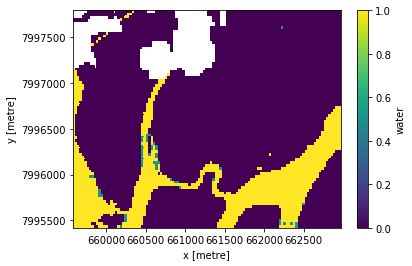

In [287]:
fig, ax = plt.subplots()
# ax.imshow(mean_dataset)
mean_dataset.plot(ax=ax)

In [179]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


create binary water mask based on summary product (based off likelihood of being persistent water bodies)

In [303]:
waterpres_prob = 0.75
water_nn = np.isnan(mean_dataset)
y_init = mean_dataset.where((mean_dataset < waterpres_prob) | (water_nn == True), 1)
y_init = y_init.where((y_init >= waterpres_prob) | (water_nn == True), 0)

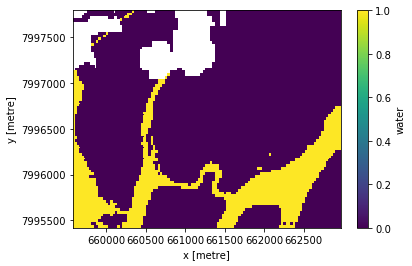

In [304]:
fig, ax = plt.subplots()
y_init.plot(ax=ax)

### load available T1 image 

- (most recent, reasonably clear image within T1-1m water masks) 
- (naturally also L8 for now, so can use existing water mask as validation)

load l8

In [294]:
product = "ls8_usgs_sr_scene"
measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

landsat_dataset = dc.load(
    product=product,
    time=time_extents,
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
landsat_dataset

<xarray.Dataset>
Dimensions:   (time: 12, x: 113, y: 79)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-03T22:00:35 ... 2018-03-31T22:06:04
  * y         (y) float64 7.998e+06 7.998e+06 7.998e+06 ... 7.995e+06 7.995e+06
  * x         (x) float64 6.596e+05 6.596e+05 6.597e+05 ... 6.629e+05 6.63e+05
Data variables:
    green     (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    red       (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    blue      (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    nir       (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    swir1     (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    swir2     (time, y, x) int16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(12, 79, 113), chunksize=(1, 79, 113)>
Attributes:
    crs:      EPSG:32760

In [264]:
# ds = l8_dataset
# for i,t in enumerate(ds.time.values):
#     fig, ax = plt.subplots()
#     ds.isel(time = i).red.plot(ax=ax);

In [295]:
# Identify pixels with valid data
good_quality = (
    (landsat_dataset.pixel_qa == 322)  | # clear
    (landsat_dataset.pixel_qa == 386)  |
    (landsat_dataset.pixel_qa == 834)  |
    (landsat_dataset.pixel_qa == 898)  |
    (landsat_dataset.pixel_qa == 1346) |
    (landsat_dataset.pixel_qa == 324)  | # water
    (landsat_dataset.pixel_qa == 388)  |
    (landsat_dataset.pixel_qa == 836)  |
    (landsat_dataset.pixel_qa == 900)  |
    (landsat_dataset.pixel_qa == 1348)
)
# Apply mask
landsat_dataset = landsat_dataset.where(good_quality)

In [296]:
img = landsat_dataset.isel(time = 5)

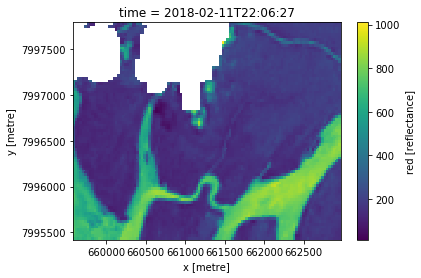

In [300]:
img.red.plot()

In [312]:
img_nn = np.isnan(img).red

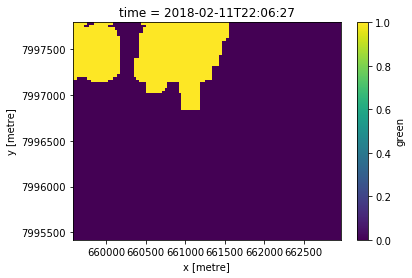

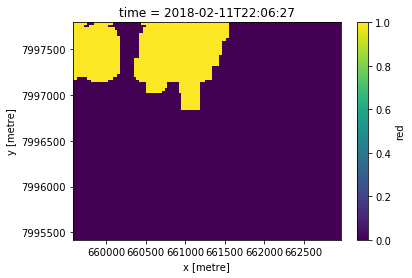

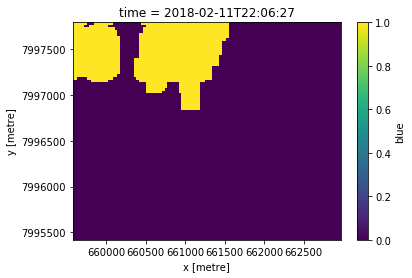

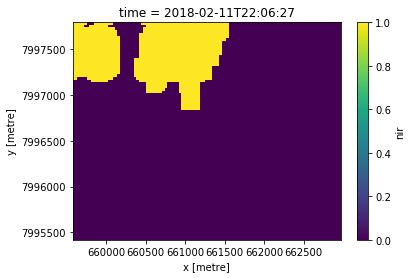

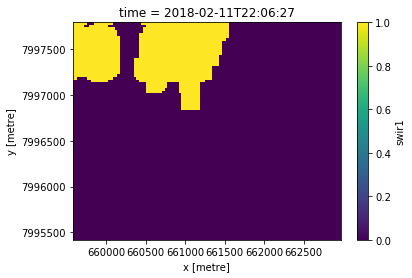

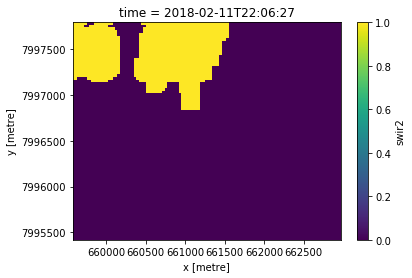

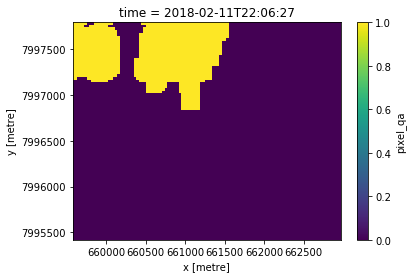

In [311]:
for m in measurements:
    fig, ax = plt.subplots()
    img_nn[m].plot(ax=ax)

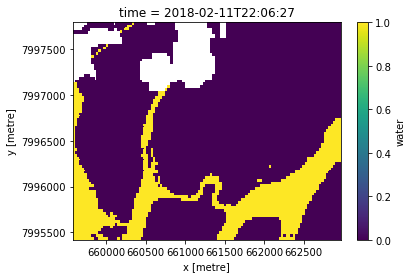

In [351]:

# merge masks for Xtrain Ytrain
Ytrain_init = y_init.where((water_nn == False) | (img_nn == False))
Ytrain_init.plot()
Xtrain_init = img.where((water_nn == False) | (img_nn == False))

# Xtrain = 

# pred & val


In [364]:
Ytrain = Ytrain_init.values.flatten()
Ytrain = Ytrain[~np.isnan(Ytrain)]
Ytrain, np.shape(np.transpose(Ytrain))

(array([0., 0., 0., ..., 0., 0., 0.]), (8138,))

In [359]:
des_vars = ['green','red','blue','nir','swir1','swir2']
Xtrain = []
for v in img.variables:
    if v in des_vars:
        Xtrain.append(Xtrain_init[v].values.flatten())
Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])

In [361]:
for i in Xtrain:
    print(np.shape(Xtrain))

(6, 7642)
(6, 7642)
(6, 7642)
(6, 7642)
(6, 7642)
(6, 7642)


In [269]:
img.variables['green']

<xarray.Variable (y: 79, x: 113)>
dask.array<shape=(79, 113), dtype=float64, chunksize=(79, 113)>
Attributes:
    units:    reflectance
    nodata:   -9999
    crs:      EPSG:32760

In [256]:
des_vars = ['green','red','blue','nir','swir1','swir2']
X_init = []
for v in img.variables:
    if v in des_vars:
        X_init.append(img[v].values.flatten())

In [259]:
X_init = np.array(X_init)

In [260]:
X_init.shape

(6, 8927)

In [240]:
np.shape(img.green.values.flatten())

AttributeError: 'function' object has no attribute 'flatten'

In [131]:
img.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:          (x: 113, y: 79)
Coordinates:
    time             datetime64[ns] 2018-02-11T22:06:27
  * y                (y) float64 7.998e+06 7.998e+06 ... 7.995e+06 7.995e+06
  * x                (x) float64 6.596e+05 6.596e+05 ... 6.629e+05 6.63e+05
Data variables:
    green            (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    red              (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    blue             (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    nir              (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    swir1            (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    swir2            (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    coastal_aerosol  (y, x) int16 dask.array<shape=(79, 113), chunksize=(79, 113)>
    pixel_qa         (y, x) uint16 dask.array<shape=(79, 113), chunksize=(79, 113)>
Attributes:

### load T1 dataset (L8 for now too)

### apply T1 dataset clearsky mask

## (2) check class distributions of T1 image w/ T1-1m water mask

set consistent query params

l8 imagery

In [31]:
# vars to update
platform = "LANDSAT_8"
product = "ls8_usgs_sr_scene"
measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}
loaded_ds = dc.load(
    time = time_range,
    group_by = 'solar_day',
    **query
)

l8 water masks

In [ ]:
# vars to update
platform = "LANDSAT_8"
product = "ls8_usgs_sr_scene"
# product = "ls8_water_classification"
measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]
# ["coastal_aerosol","scene_classification"], ["pixel_qa"], ["water"]

query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}
loaded_ds = dc.load(
    time = time_range,
    group_by = 'solar_day',
    **query
)

In [ ]:
msk = 

check imgs

In [ ]:
ds = loaded_ds

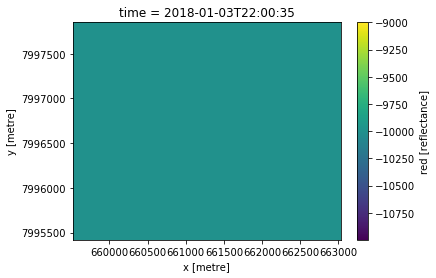

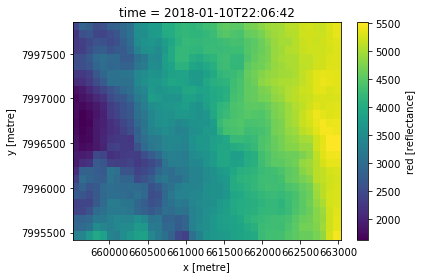

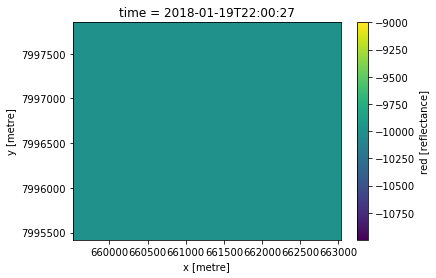

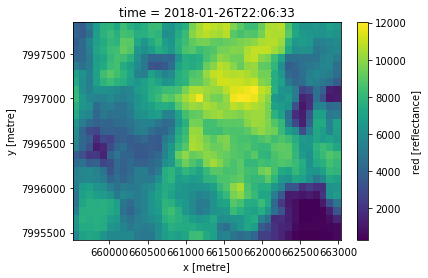

In [39]:
for i,t in enumerate(ds.time.values):
    fig, ax = plt.subplots()
    ds.isel(time = i).red.plot(ax=ax);

In [28]:
dc.list_measurements()

aliases  \
product                  measurement                                                       
ls4_usgs_sr_scene        blue                                         [band_1, sr_band1]   
                         green                                        [band_2, sr_band2]   
                         red                                          [band_3, sr_band3]   
                         nir                                          [band_4, sr_band4]   
                         swir1                                        [band_5, sr_band5]   
                         swir2                                        [band_7, sr_band7]   
                         sr_atmos_opacity                                     [atmos_op]   
                         pixel_qa                                             [pixel_qa]   
                         radsat_qa                                           [radsat_qa]   
                         sr_cloud_qa                                          [pixel_qa]   
ls4_water_classification water                              [wofs, water_classification]   
ls5_usgs_sr_scene        blue                                         [band_1, sr_band1]   
                         green                                        [band_2, sr_band2]   
                         red                                          [band_3, sr_band3]   
                         nir                                          [band_4, sr_band4]   
                         swir1                                        [band_5, sr_band5]   
                         swir2                                        [band_7, sr_band7]   
                         sr_atmos_opacity                                     [atmos_op]   
                         pixel_qa                                             [pixel_qa]   
                         radsat_qa                                           [radsat_qa]   
                         sr_cloud_qa                                          [pixel_qa]   
ls5_water_classification water                              [wofs, water_classification]   
ls7_usgs_sr_scene        blue                                         [band_1, sr_band1]   
                         green                                        [band_2, sr_band2]   
                         red                                          [band_3, sr_band3]   
                         nir                                          [band_4, sr_band4]   
                         swir1                                        [band_5, sr_band5]   
                         swir2                                        [band_7, sr_band7]   
                         sr_atmos_opacity                                     [atmos_op]   
                         pixel_qa                                             [pixel_qa]   
...                                                                                  ...   
ls8_usgs_fc_scene        NPV                                                  [dead_veg]   
                         UE                                                        [err]   
ls8_usgs_sr_scene        coastal_aerosol                              [band_1, sr_band1]   
                         blue                                         [band_2, sr_band2]   
                         green                                        [band_3, sr_band3]   
                         red                                          [band_4, sr_band4]   
                         nir                                          [band_5, sr_band5]   
                         swir1                                        [band_6, sr_band6]   
                         swir2                                        [band_7, sr_band7]   
                         pixel_qa                                             [pixel_qa]   
                         sr_aerosol                 [sr_aerosol_qa, aerosol_qa, aerosol]   
                         radsat_q

In [ ]:
aoi_wkt = "POLYGON((178.5084149387392 -18.103042187047517,178.54017229347554 -18.103042187047517,178.54017229347554 -18.12392593522968,178.5084149387392 -18.12392593522968,178.5084149387392 -18.103042187047517))"
lat_extents, lon_extents = create_lat_lon(aoi_wkt)
output_projection = "EPSG:32760"
res = 90
resolution = (-res, res)
time_start = ('2018-1-1')
time_end = ('2018-2-1')
platform = "LANDSAT_8"
def createDate(inputDate):
    outputDate = datetime.strptime(inputDate, '%Y-%m-%d')
    outputDates = outputDate.date()
    return outputDates
dateStart = createDate(time_start)
dateEnd = createDate(time_end)
time_range = (dateStart, dateEnd)

allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}